### Use a SOM to construct feature likelihood

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
import sys
sys.path.append('../python')

import som
import time
import seaborn as sns
import pandas as pd

from astropy.table import Table

In [3]:
from GCR import GCRQuery
import GCRCatalogs

Define global variables:

In [4]:
rng = np.random.RandomState(seed=14)
res = -100

#### Generate SOM using random data

In [5]:
n_deep = int(131e3)
n_phot = 500000

rndm_deep = rng.uniform(high=10.0, size=(n_deep,3))
rndm_phot = rng.uniform(high=10.0, size=(n_phot,3))
## Generate 'target feature' (i.e. redshift) values that are correlated with the photometric sample in some way
## Will see a degeneracy in the map when sampling based on mean of all the features
rndm_z = rng.normal(loc=np.mean(rndm_phot.view(float), axis=1), scale=0.5 * np.std(rndm_phot))

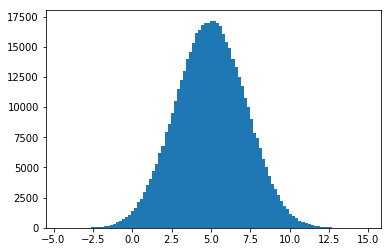

In [6]:
plt.hist(rndm_z, bins=100)
plt.show()

In [7]:
rndm_deep_df = pd.DataFrame(rndm_deep, columns=('x', 'y', 'z'))
rndm_phot_df = pd.DataFrame(rndm_phot, columns=('x', 'y', 'z'))

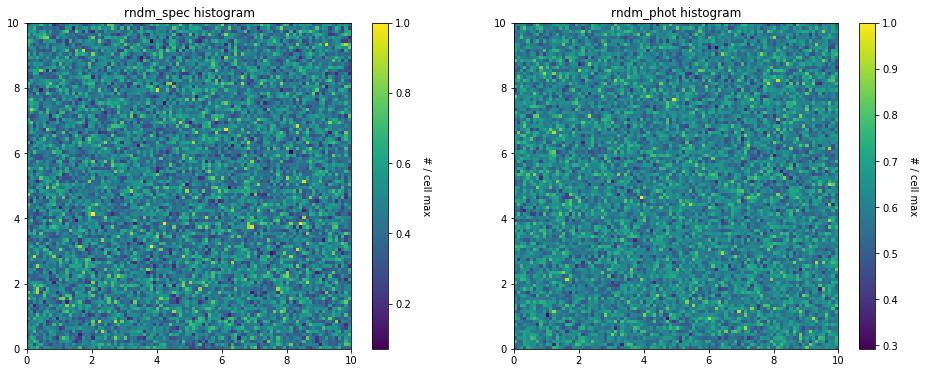

In [8]:
som.deep_phot_hist2d(rndm_deep_df, rndm_phot_df, cols=['x', 'y'], bins=np.abs(res))

158.82600831985474


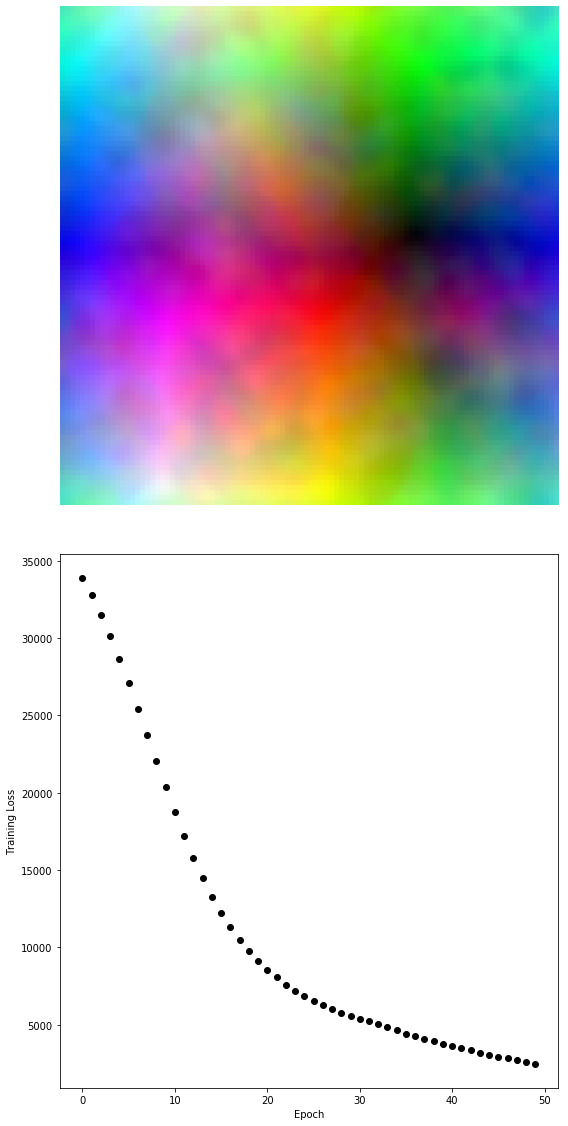

In [9]:
start = time.time()
rndm_som = som.make_som(rndm_deep[::15], nmap=res, niter=50, rgb=[0,1,2])
print(time.time() - start)

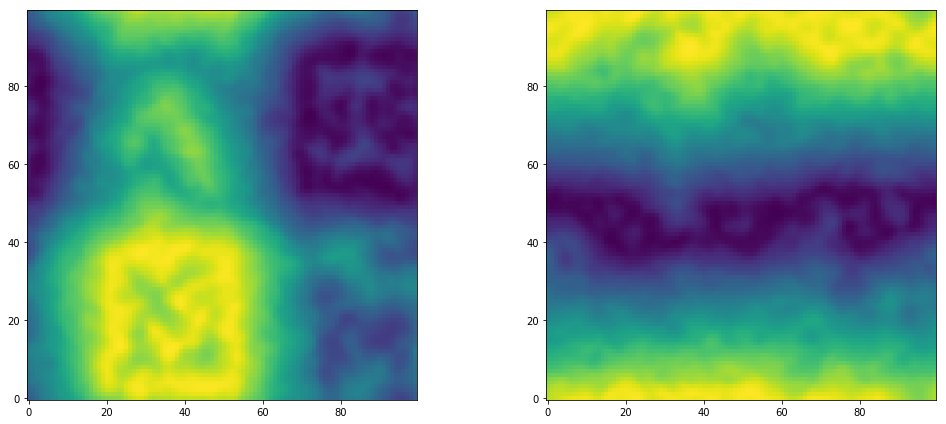

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs = axs.ravel()

for i in range(2):
    axs[i].imshow(rndm_som[:,:,i], origin='lower', interpolation='none')
    
plt.tight_layout()
plt.show()

Make a histogram of weight values for deep sample, photometric sample, and SOM:

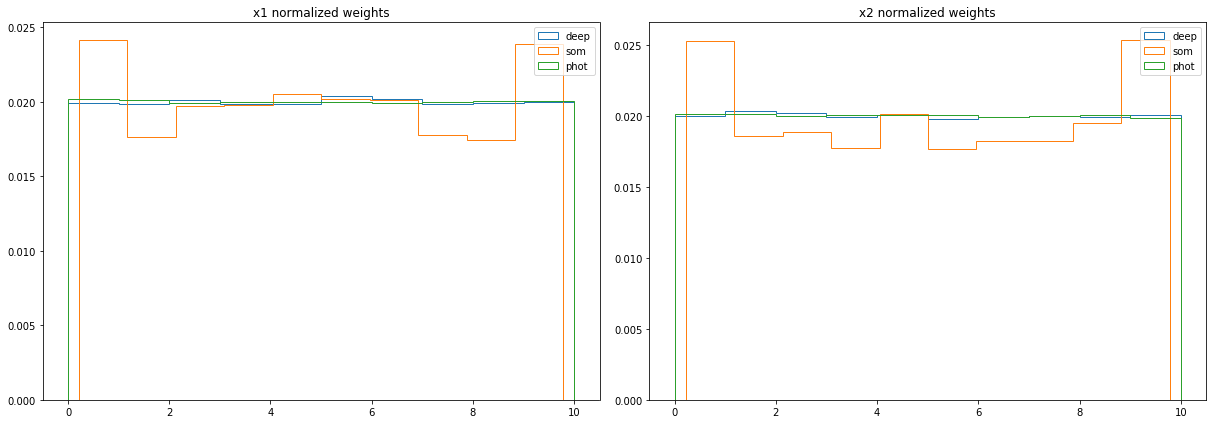

In [11]:
fig, axs = plt.subplots(1,2, figsize=(17,6))
axs = axs.ravel()

rows, cols, D = rndm_som.shape

axs[0].hist(rndm_deep[:,0], weights=np.ones(len(rndm_deep)) / np.sum(rndm_deep[:,0]), histtype='step', label='deep')
axs[0].hist(rndm_som.reshape(rows * cols, D)[:,0], weights=np.ones(rows * cols) / np.sum(rndm_som.reshape(rows * cols, D)[:,0]), histtype='step', label='som')
axs[0].hist(rndm_phot[:,0], weights=np.ones(len(rndm_phot)) / np.sum(rndm_phot[:,0]), histtype='step', label='phot')
axs[0].set_title('x1 normalized weights')
axs[0].legend()

axs[1].hist(rndm_deep[:,1], weights=np.ones(len(rndm_deep)) / np.sum(rndm_deep[:,1]), histtype='step', label='deep')
axs[1].hist(rndm_som.reshape(rows * cols, D)[:,1], weights=np.ones(rows * cols) / np.sum(rndm_som.reshape(rows * cols, D)[:,1]), histtype='step', label='som')
axs[1].hist(rndm_phot[:,1], weights=np.ones(len(rndm_phot)) / np.sum(rndm_phot[:,1]), histtype='step', label='phot')
axs[1].set_title('x2 normalized weights')
axs[1].legend()

plt.tight_layout()
plt.show()

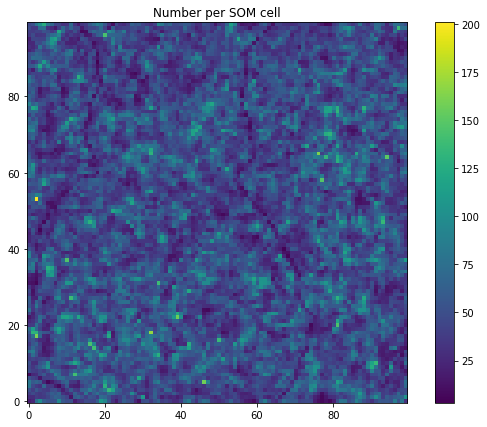

In [12]:
rows, cols, D = rndm_som.shape
som_indices, counts = som.map_phot_to_som(rndm_phot, rndm_som)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

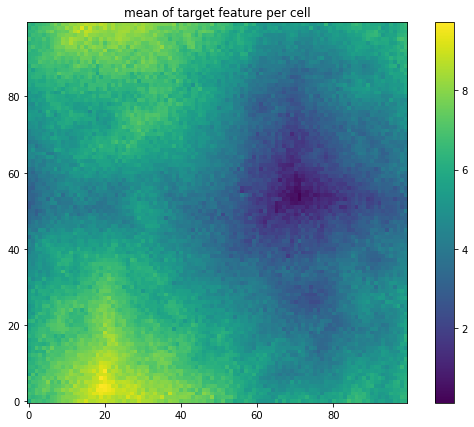

In [13]:
som.plot_statistic(som_indices, counts, rndm_z, rows, cols, statistic=np.mean)

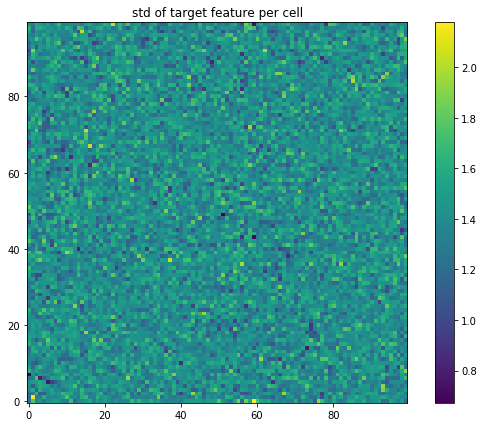

In [14]:
som.plot_statistic(som_indices, counts, rndm_z, rows, cols, statistic=np.std)

###### to do: plot SED as a function of central wavelength in each filter band

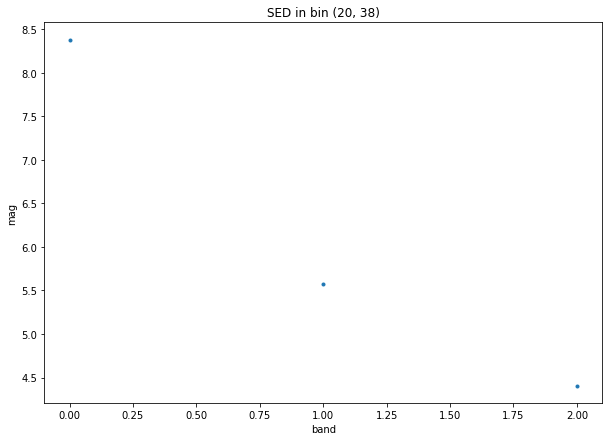

In [15]:
som.plot_sed_in_cell(rndm_phot, som_indices, cols, rng, idx=(20,38))

#### Load cosmoDC2 data

If running for the first time, access the data via the GCR. Otherwise reload an existing copy of the data.

In [16]:
reload = True

In [17]:
if not reload:

    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

    # Define coordinate cuts

    # 4 x 4 sq deg patch
    deg = 4 
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    alpha = 0.78 
    beta = (0.5 * deg) * (1/alpha - 1)

    ra_min = 62.5 - beta
    ra_max = 66.5 + beta
    dec_min = -41.
    dec_max = -37.

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]

    # Define magnitude cuts

    mag_filters = [
        'mag_r < 26.3',
        'mag_i < 26.3',
    ]

    # Apply all cuts
    gc_data_mag_cut = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_i', 'mag_g', 'mag_r', 'mag_u', 'mag_y', 
                                         'mag_z'], filters=(coord_filters + mag_filters))

    u = gc_data_mag_cut['mag_u']
    g = gc_data_mag_cut['mag_g']
    r = gc_data_mag_cut['mag_r']
    i = gc_data_mag_cut['mag_i']
    z = gc_data_mag_cut['mag_z']
    y = gc_data_mag_cut['mag_y']

    u_g = u - g
    g_r = g - r
    r_i = r - i
    i_z = i - z
    z_y = z - y

    redshift = gc_data_mag_cut['redshift']
    colors = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
    mags = np.asarray([u, g, r, i, z, y]).T

    mags_table = Table(mags, names=['u', 'g', 'r', 'i', 'z', 'y'])
    colors_table = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    redshift_table = Table(redshift.reshape(-1,1), names=['redshift'])

    overwrite = True
    mags_table.write('../data/feature_likelihood/dc2_mags.fits', format='fits', overwrite=overwrite)
    colors_table.write('../data/feature_likelihood/dc2_colors.fits', format='fits', overwrite=overwrite)
    redshift_table.write('../data/feature_likelihood/dc2_redshift.fits', format='fits', overwrite=overwrite)

In [18]:
if reload: 
    mags = Table.read('../data/feature_likelihood/dc2_mags.fits', format='fits')
    colors = Table.read('../data/feature_likelihood/dc2_colors.fits', format='fits')
    redshift = Table.read('../data/feature_likelihood/dc2_redshift.fits', format='fits')

#### Visualize the data as a pairplot

In [19]:
df = pd.DataFrame(np.asarray(colors), columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y'))

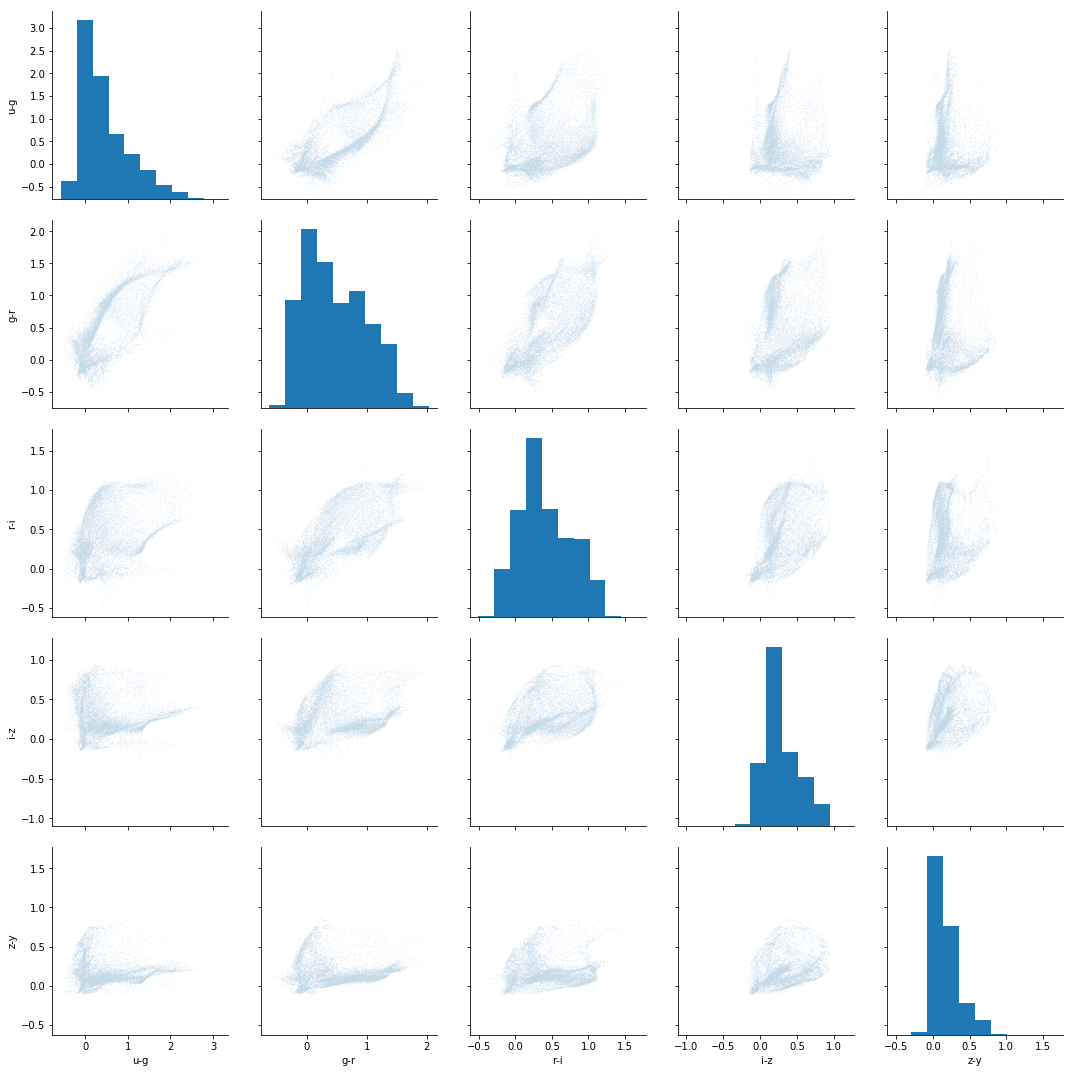

In [31]:
sns.pairplot(df[::200], kind='scatter', height=3, aspect=1, plot_kws={'s':0.5, 'alpha': 0.1})

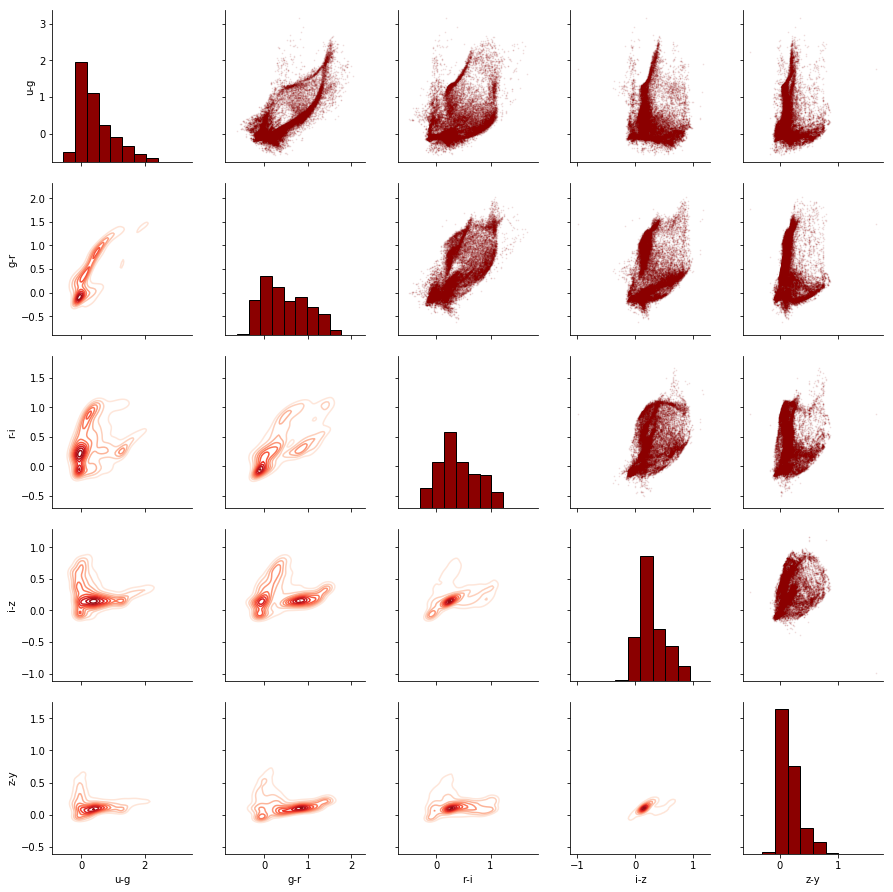

In [32]:
grid = sns.PairGrid(data=df[::200])

# Map a scatter plot to the upper triangle
grid = grid.map_upper(plt.scatter, color = 'darkred', alpha=0.1, s=0.5)

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

#### DC2 Diagnostic Plots

In [22]:
n_deep = int(131e3)
n_phot = 500000

In [135]:
dc2_deep = colors[:n_deep]
dc2_phot = colors[n_deep:n_deep + n_phot]
dc2_z = redshift[n_deep:n_deep + n_phot]
dc2_mags = mags[n_deep:n_deep + n_phot]

###### add x, y labels

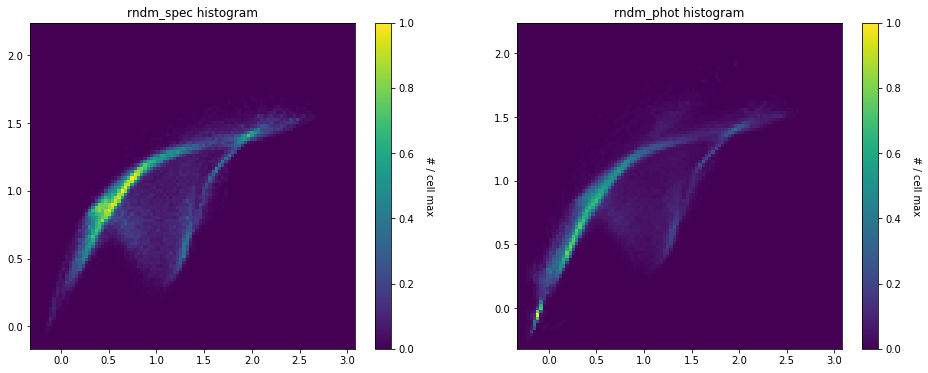

In [35]:
som.deep_phot_hist2d(dc2_deep, dc2_phot, cols=['u-g', 'g-r'], bins=np.abs(res))

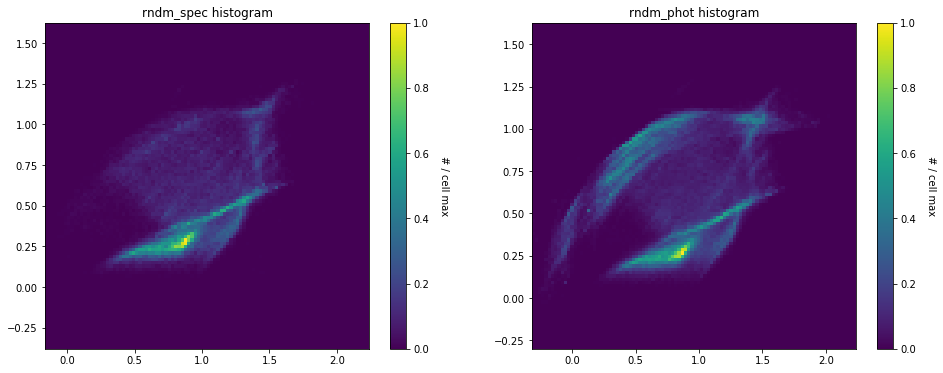

In [37]:
som.deep_phot_hist2d(dc2_deep, dc2_phot, cols=['g-r', 'r-i'], bins=np.abs(res))

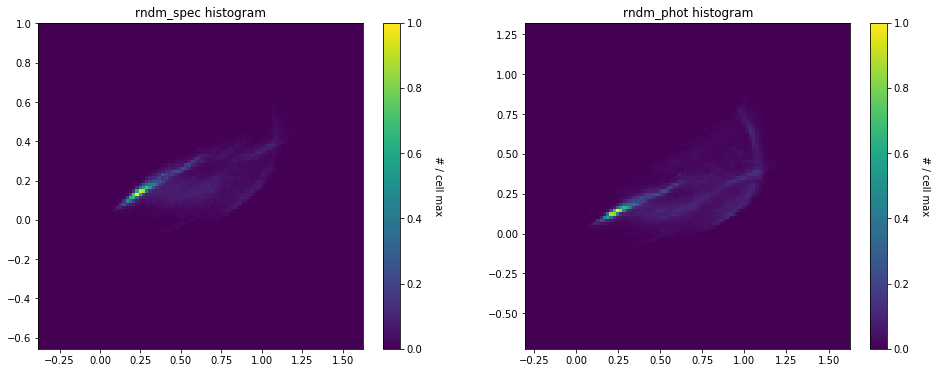

In [36]:
som.deep_phot_hist2d(dc2_deep, dc2_phot, cols=['r-i', 'i-z'], bins=np.abs(res))

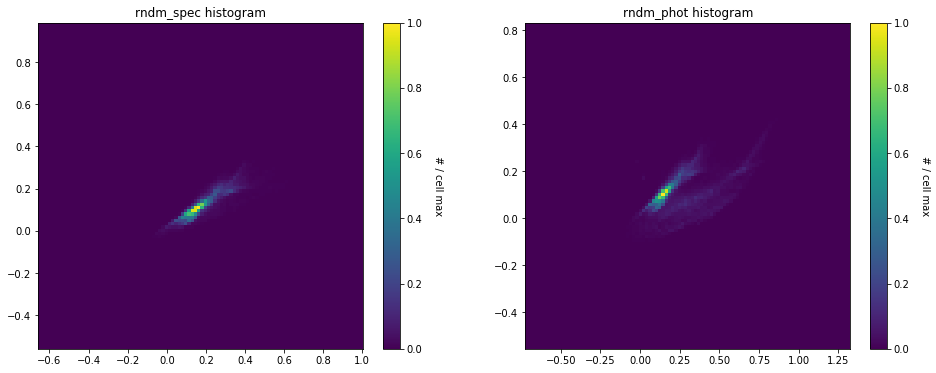

In [39]:
som.deep_phot_hist2d(dc2_deep, dc2_phot, cols=['i-z', 'z-y'], bins=np.abs(res))

183.47695446014404


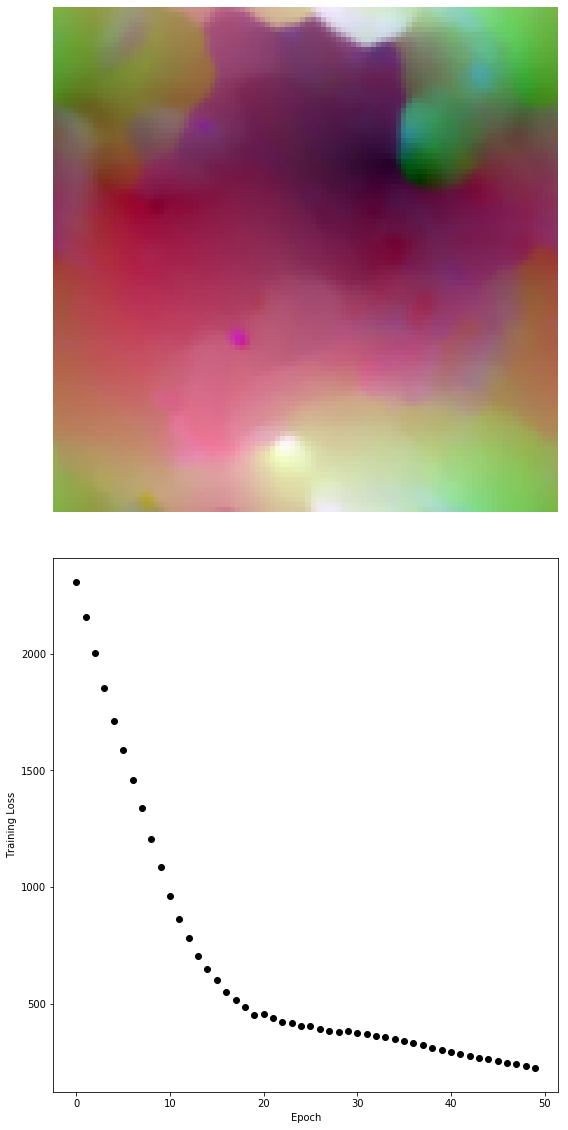

In [30]:
start = time.time()
dc2_som = som.make_som(dc2_deep[::15], nmap=res, niter=50, rgb=[1,2,3])
print(time.time() - start)

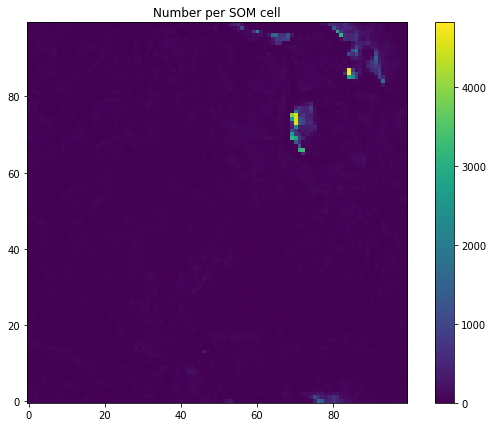

In [32]:
rows, cols, D = dc2_som.shape
som_indices, counts = som.map_phot_to_som(dc2_phot, dc2_som)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

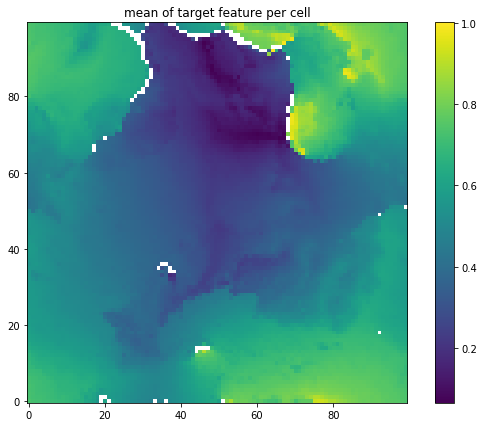

In [34]:
som.plot_statistic(som_indices, counts, dc2_z['redshift'], rows, cols, statistic=np.mean)

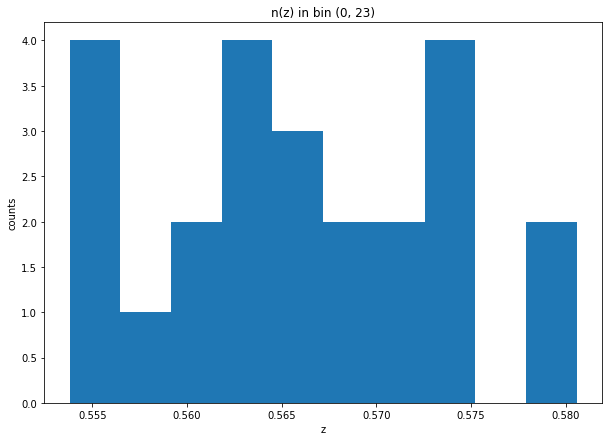

In [35]:
som.plot_dist_in_cell(som_indices, dc2_z['redshift'], cols, idx=(0,23))

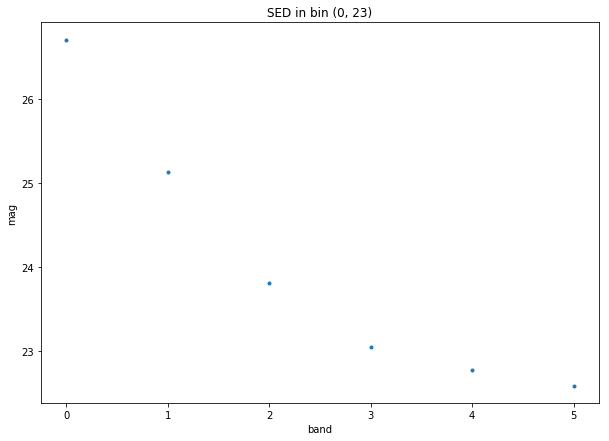

In [36]:
som.plot_sed_in_cell(dc2_mags, som_indices, cols, rng, idx=(0, 23))

#### Incorporate errors into SOM

In [54]:
def select_colors(color_data, color):
    
    err = np.std(color_data[color])
    mu = color_data[color]
    
    return(rng.normal(loc=mu, scale=np.full(len(color_data), err)))


def add_errs(color_data):
    
    u_g = select_colors(colors, 'u-g')
    g_r = select_colors(colors, 'g-r')
    r_i = select_colors(colors, 'r-i')
    i_z = select_colors(colors, 'i-z')
    z_y = select_colors(colors, 'z-y')
    
    colors_w_errs = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
    
    return(Table(colors_w_errs, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y']))

In [62]:
if reload:
    colors_w_errs = Table.read('../data/feature_likelihood/dc2_colors_w_errs.fits', format='fits')
else:
    colors_w_errs = add_errs(colors)
    colors.write('../data/feature_likelihood/dc2_colors_w_errs.fits', format='fits', overwrite=overwrite)

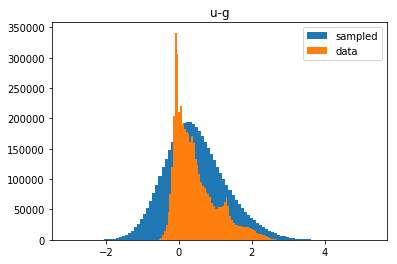

In [56]:
plt.hist(colors_w_errs['u-g'], bins=100, label='sampled')
plt.hist(colors['u-g'], bins=100, label='data')
plt.title('u-g')
plt.legend()
plt.show()

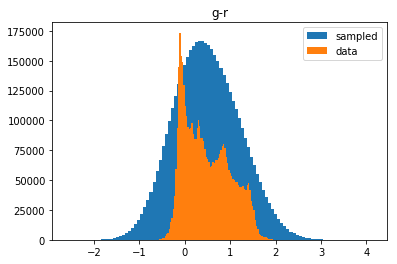

In [57]:
plt.hist(colors_w_errs['g-r'], bins=100, label='sampled')
plt.hist(colors['g-r'], bins=100, label='data')
plt.title('g-r')
plt.legend()
plt.show()

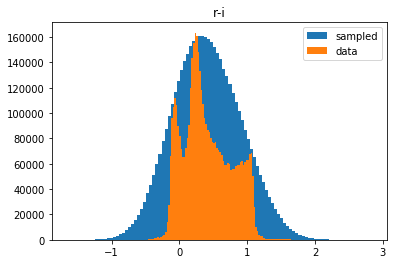

In [58]:
plt.hist(colors_w_errs['r-i'], bins=100, label='sampled')
plt.hist(colors['r-i'], bins=100, label='data')
plt.title('r-i')
plt.legend()
plt.show()

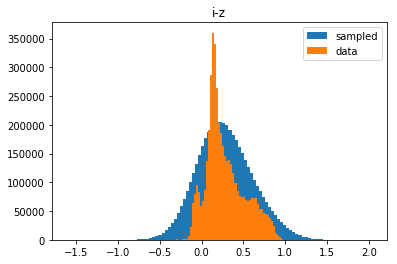

In [59]:
plt.hist(colors_w_errs['i-z'], bins=100, label='sampled')
plt.hist(colors['i-z'], bins=100, label='data')
plt.title('i-z')
plt.legend()
plt.show()

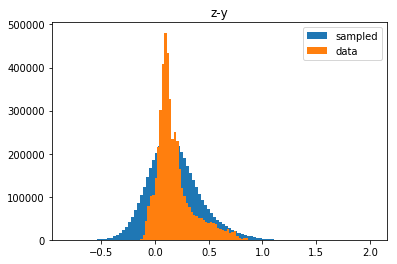

In [60]:
plt.hist(colors_w_errs['z-y'], bins=100, label='sampled')
plt.hist(colors['z-y'], bins=100, label='data')
plt.title('z-y')
plt.legend()
plt.show()

Is sampling from a Gaussian going to be accurate? Colors don't look normally-distributed ...

#### Look at SOM generated with:
`n_deep = 131k, res=-100, n_iter=100`

In [63]:
dc2_som_131k = np.load('/global/cscratch1/sd/belaa/lsst/pz/batch_scripts/som_output/dc2_som_131000_100.npy')

##### make function that gives you an rgb image from som output

In [65]:
dc2_som_131k_img = som.u_matrix(dc2_som_131k)

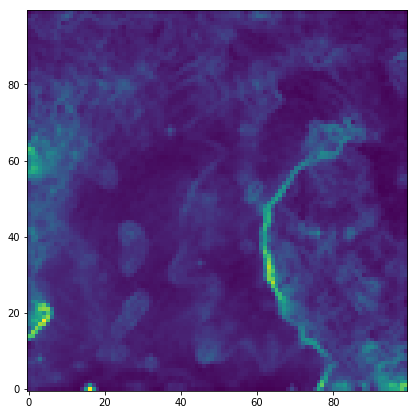

In [66]:
plt.figure(figsize=(10,7))
plt.imshow(dc2_som_131k_img, origin='low', interpolation='none')
plt.show()

In [138]:
def quant_error(phot_data, som_indices, som_weights):
    
    """Average quantization error (from Masters et al. 2015 Eq. 7)"""
    
    phot_data = np.asarray(phot_data)
    phot_data_view = phot_data.view((phot_data.dtype[0], len(phot_data.dtype.names)))
    
    N = len(phot_data)
    
    dx = phot_data_view - som_weights[som_indices,:]
    dist = np.sqrt(np.sum(dx ** 2))
    qe = np.sum(dist, axis=0) / N
    
    return(qe)

In [141]:
quant_error(dc2_phot, som_indices, dc2_som.reshape(abs(res) * abs(res), -1))

0.00015363325323380702